<h1 style="text-align: center;"><b>Longstaff-Schwarz/Least-Squares Method</b></h1>

#### Maksim Sosnin


Let $S$ be the price of the underlying, $V_t(S)$ – option value, $\Psi(S)$ – payoff, $T$ – maturity, $r$ – risk-free rate.

We can approximate American option with a Bermudan option, which can be exercised at specified discrete dates:
$$\Delta t := \frac{T}{M},\quad t_j := j \Delta t\ (j = 0, ..., M),$$
where $T$ is maturity, $M$ – number of time steps.

### Dynamic programming
$V_{t_M}(S) = \Psi(S)\ $ – payoff.

$C_{t_n}(S) := e^{-r \Delta t}\ \mathbb{E}[V_{t_{n+1}}(S_{t_{n+1}}) | S_{t_n} = S]\ $ – continuation or holding value. Needs to be approximated, e.g. by regression.

$V_{t_n}(S) = \max[C_{t_n}(S), \Psi(S)].$

### LSM algorithm (Monte-Carlo + Regression)
1. Simulate $N$ paths $S_1(t), ... , S_N(t)$ with $M$ time steps:
    $$S_{j,k} := S_k(t_j),\quad j = 1, ..., M,\ k = 1, ..., N.$$
2. For $k = 1, ..., N$ set
    - $g_k := \Psi(S_{M,k})$ – cashflow vector,
    - $\tau_k = M$ – integer stopping time vector.
3. For $j = M - 1, ..., 1$:
    For the subset of in-the-money points $(x_k, y_k) := (S_{j,k}, e^{-r(\tau_k-j)\Delta t} g_k)$:
    - Approximate $C_j(x)$ using suitable basis functions $\phi_0, ..., \phi_L$ (for example, monomials) by least squares over the ITM points:
        $$C_j(x) \approx \sum_{l=0}^L a_l \phi_l(x) =: \hat C_j(x).$$
    - For those $k$ with $\Psi(S_{j,k}) \geq \hat C_j(S_{j,k})$ update
        $$g_k := \Psi(S_{j,k}),\quad \tau_k := j.$$
4. Finally, set
    $$\hat C_0 := \frac{1}{N} \sum_{k=1}{N} e^{-r\tau_k \Delta t} g_k, \quad V_0 := \max\{\Psi(S_0), \hat C_0\}.$$


For more in-depth explanation of LSM algorithm, see [Seydel2017, section 3.6.3] and the original article [LongstaffSchwartz2001].


### LSM algorithm modification

We can divide the LSM algorithm into two steps:
1. *Regression.* Apply the algorithm described in the previous section to find the approximation $\hat C_{t_n}(S)$ of continuation value at each time step.
2. *Pricing.* Simulate a new set of paths with the same parameters. Use the time and price dependent continuation value from step 1 as a sort of barrier:  when the payoff for a given path crosses $\hat C_{t_n}(S)$, exercise the option on this path.

This approach solves several problems. Firstly, we can easily apply automatic differentiation to find the Greeks, because we can disable it on the first step and enable it only on the second step, using the continuation value as a precomputed barrier. By doing this, we avoid differentiating the least-squares regression, which can be computationally expensive. Secondly, we reduce the bias by using different set of paths on the second step, which makes the computed option price more accurate.

# Implementation of LSM algorithm

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from pyquant.lsm import price_american_put_lsm, LSMResult
from pyquant.bsm import price_american_put_bsm, find_early_exercise

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
def generate_gbm(n_paths, n_steps, dt, S0, sigma, drift):
    paths_gbm = S0 * torch.cumprod(
        1 + drift*dt + sigma * (dt**0.5) * torch.randn((n_paths, n_steps)), dim=1)
    paths_gbm = torch.hstack((S0 * torch.ones((n_paths, 1)), paths_gbm))
    return paths_gbm

In [3]:
def plot_paths(dt, n_steps, paths, strike, title=''):
    time_arr = np.linspace(0, n_steps * dt, n_steps + 1)
    for i in range(len(paths)):
        plt.plot(time_arr, paths.detach().numpy()[i])
    plt.axhline(strike, ls='--', label='Strike', c='darkred')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

In [4]:
POLY_DEGREE = 3

N_PATHS = 200_000
T_DAYS = 60
DT = 0.5 / 365
N_STEPS = round(T_DAYS / (DT * 365))

S0 = torch.tensor(100.0, requires_grad=True)
SIGMA = torch.tensor(0.3, requires_grad=True)
STRIKE = torch.tensor(S0.item() * 0.95)
RATE = torch.tensor(0.03)

print(f'N_STEPS: {N_STEPS}')

N_STEPS: 120


In [5]:
paths1 = generate_gbm(N_PATHS, N_STEPS, DT, S0, SIGMA, RATE)
paths2 = generate_gbm(N_PATHS, N_STEPS, DT, S0, SIGMA, RATE)

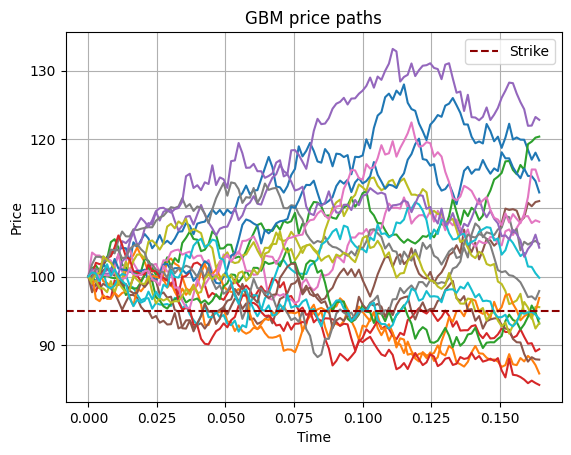

In [6]:
plot_paths(DT, N_STEPS, paths1[:20], STRIKE, title='GBM price paths')

In [7]:
lsm_res = price_american_put_lsm(
    paths1,
    paths2,
    DT,
    STRIKE,
    RATE,
    reg_poly_degree=POLY_DEGREE,
    return_extra=True
)

In [8]:
delta = torch.autograd.grad(lsm_res.option_price, [S0])

In [9]:
print(f'Price of American put: {lsm_res.option_price:.5f}')
print(f'Delta Greek: {delta[0].item():.5f}')

Price of American put: 2.50103
Delta Greek: -0.30857


## Visualization of LSM algorithm

Let's look at the computed approximations of continuation value curves $\hat C_j (x)$ and in-the-money points $(x_k, y_k) := (S_{j,k}, e^{-r(\tau_k-j)\Delta t} g_k)$ – the data for regression, at different time steps $j$.

In [10]:
def visualize_lsm(
    idx: int,
    paths: torch.Tensor,
    lsm_res: LSMResult,
    reg_poly_degree: int
):
    vander = torch.vander(lsm_res.reg_x_vals[idx], N=reg_poly_degree + 1)
    C_hat = torch.matmul(vander, lsm_res.reg_poly_coefs[idx])  # continuation value

    S_space = torch.linspace(min(paths[:, idx]).item() - 7, max(paths[:, idx]).item() + 7, 1000)
    payoff = np.maximum(STRIKE - S_space, 0)
    
    fig = go.Figure(data=[
        go.Scatter(x=lsm_res.reg_x_vals[idx], y=lsm_res.reg_y_vals[idx], marker_size=1.3,
                   mode='markers', marker_color='blue', name='ITM points $(x_k, y_k)$'),
        go.Scatter(x=S_space, y=payoff, line_color='black', name='Payoff $\Psi(S)$'),
        go.Scatter(x=lsm_res.reg_x_vals[idx], y=C_hat, marker_size=3, marker_color='orange',
                   mode='markers', name='Continuation value $\hat C_j(x)$')
    ])

    fig.add_vline(x=STRIKE, line_dash='dash', annotation_text='Strike', line_color='darkred')
    fig.update_layout(title=f't = {idx * DT:.3f}, (j = {idx}, n_steps = {N_STEPS})',
                      xaxis_title='S', width=900, height=700,
                      xaxis_range=[min(S_space), 100],
                      legend={'itemsizing': 'constant'})
    return fig

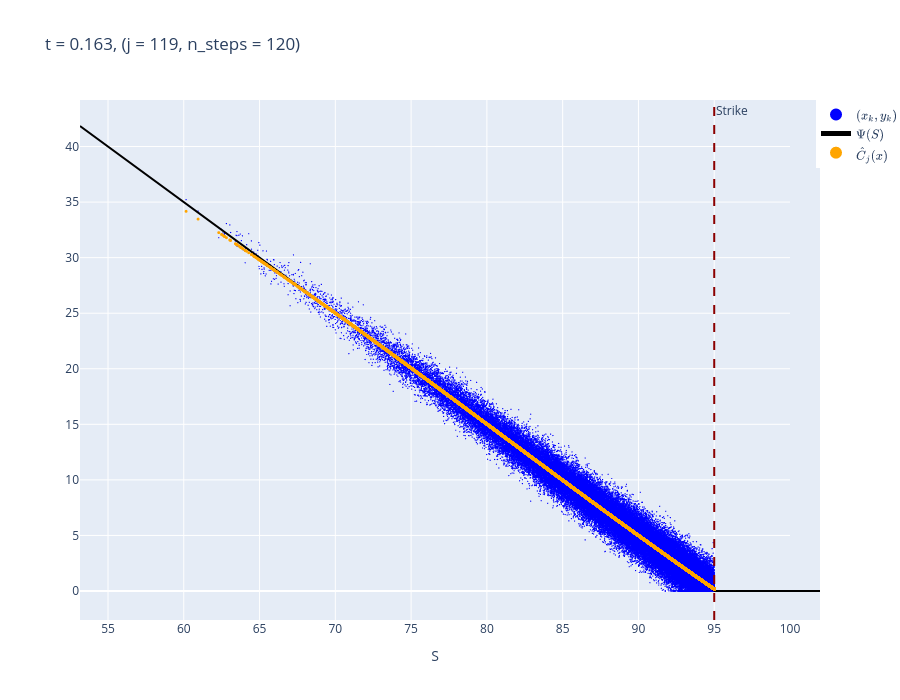

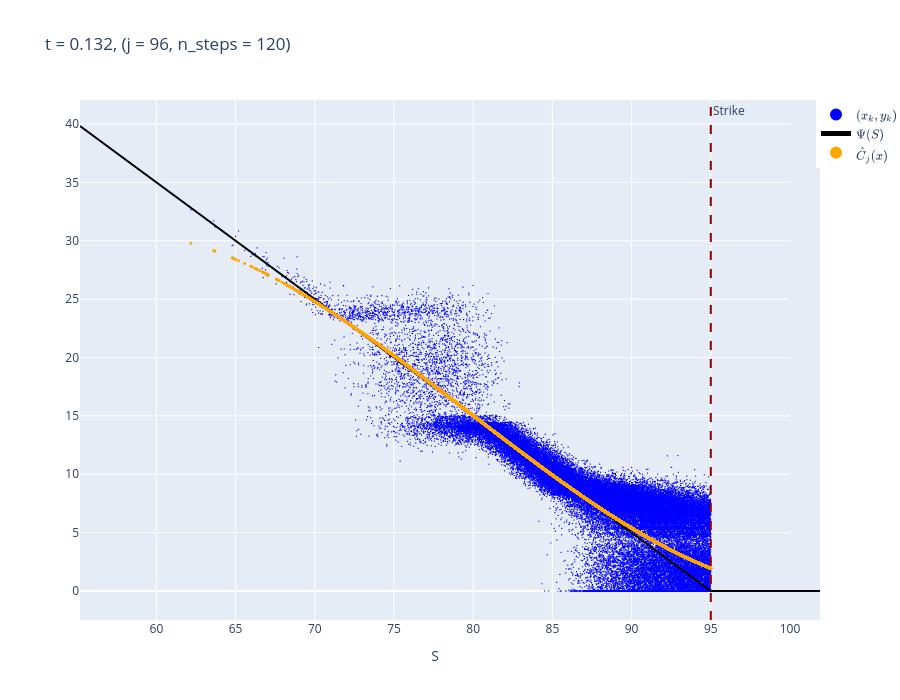

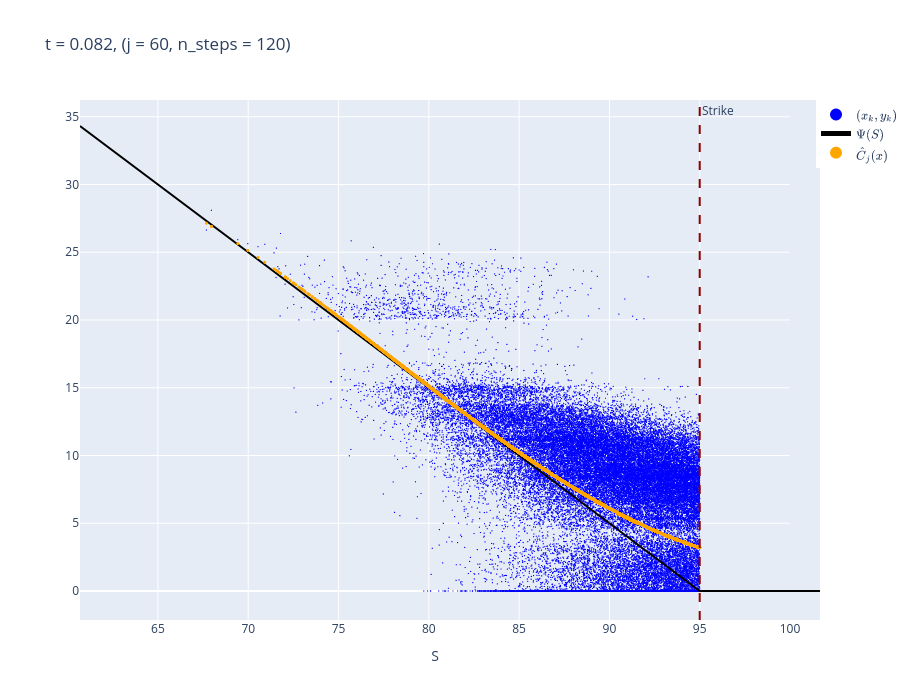

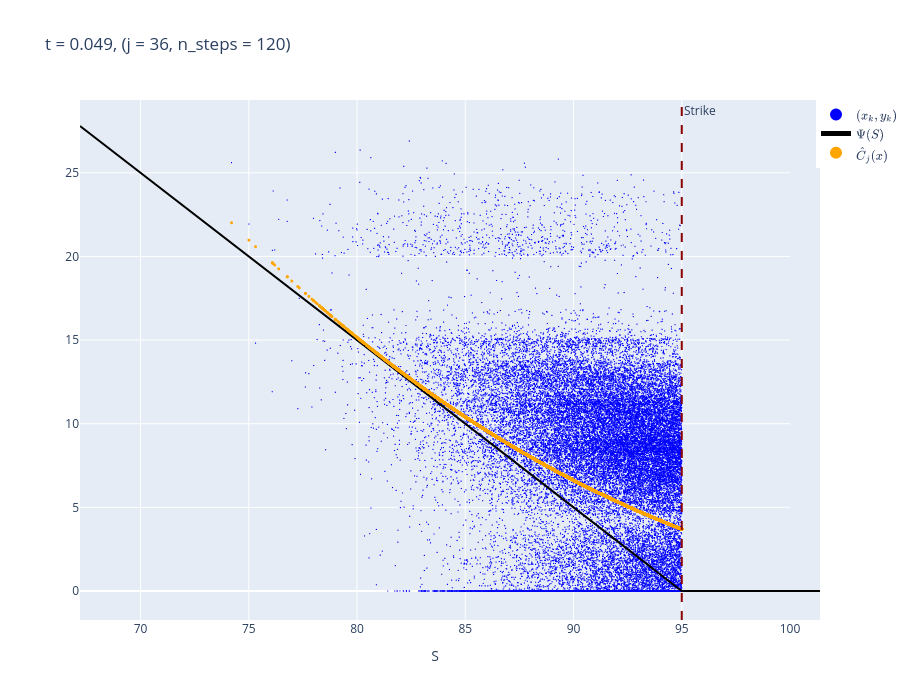

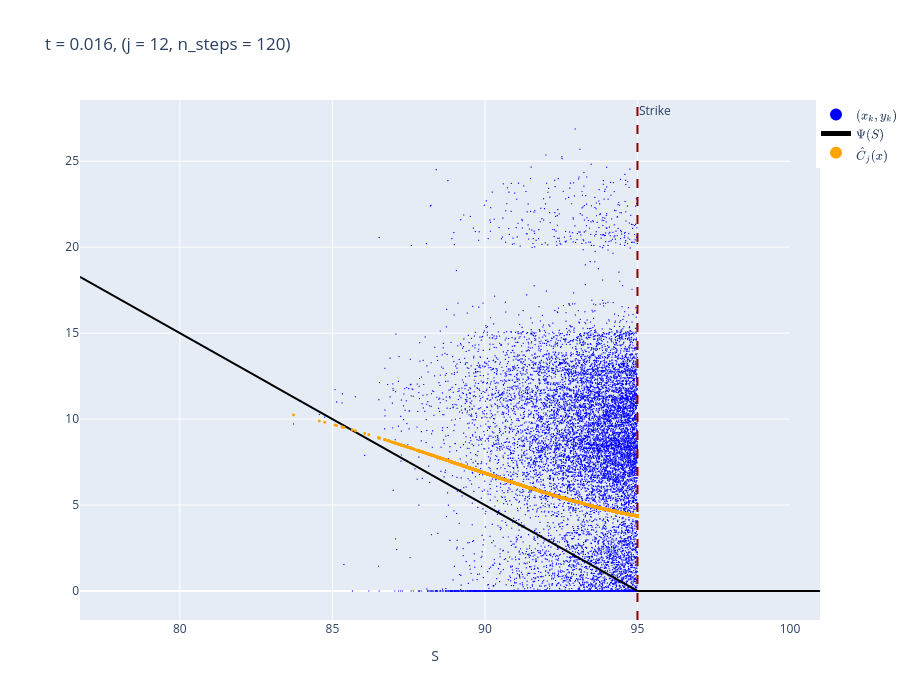

In [11]:
# Use show() without arguments to have interactive plots
visualize_lsm(N_STEPS - 1, paths1, lsm_res, POLY_DEGREE).show(renderer='png')
visualize_lsm(round(N_STEPS * 0.8), paths1, lsm_res, POLY_DEGREE).show(renderer='png')
visualize_lsm(round(N_STEPS * 0.5), paths1, lsm_res, POLY_DEGREE).show(renderer='png')
visualize_lsm(round(N_STEPS * 0.3), paths1, lsm_res, POLY_DEGREE).show(renderer='png')
visualize_lsm(round(N_STEPS * 0.1), paths1, lsm_res, POLY_DEGREE).show(renderer='png')

## Comparison with Brennan-Schwartz algorithm

For Black-Scholes model, we can compare the prices obtained via LSM and Brennan-Schwartz (see [bsm.ipynb](bsm.ipynb)) algorithms.

In [12]:
T = N_STEPS * DT
S_min = 30
S_max = 200
npoints_S = 3000
npoints_t = 3000
TOL = 1e-5

V_bsm, S_arr, t_arr = price_american_put_bsm(
    STRIKE.item(),
    T,
    RATE.item(),
    SIGMA.item(),
    S_min,
    S_max,
    npoints_S,
    npoints_t
)

_, stop_S_bsm = find_early_exercise(V_bsm, S_arr, t_arr, STRIKE.item(), TOL)

delta_tau / delta_x**2 = 6.163930983295377


In [13]:
price_bsm = V_bsm[np.argmin(np.abs(S_arr - S0.item())), -1]
rel_diff = (lsm_res.option_price.item() - price_bsm) / price_bsm

In [14]:
print(f'LSM price: {lsm_res.option_price}')
print(f'Brennan-Schwartz price: {price_bsm}')
print(f'Relative difference: {rel_diff * 100}%')

LSM price: 2.50102654852153
Brennan-Schwartz price: 2.4975296089601953
Relative difference: 0.14001594010293114%


We can see that LSM algorithm produces results which are close to the Brennan-Schwartz algorithm.

# References

- [LongstaffSchwartz2001] [Longstaff, F. A., & Schwartz, E. S. (2001). Valuing American options by simulation: a simple least-squares approach. The review of financial studies, 14(1), 113-147.](http://deriscope.com/docs/Longstaff_Schwarz_2001.pdf)
- [Seydel2017] [Seydel, Rüdiger. Tools for computational finance. Sixth edition. Springer, 2017.](https://link.springer.com/book/10.1007/978-1-4471-7338-0) Section 3.6.3.
- [Huge2017] [Huge, B. N., & Savine, A. (2017). LSM Reloaded-Differentiate xVA on your iPad Mini. Available at SSRN 2966155.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2966155)
- [Jonen2011] [Jonen, C. (2011). Efficient pricing of high-dimensional American-style derivatives: A robust regression Monte Carlo method (Doctoral dissertation, Universität zu Köln).](https://kups.ub.uni-koeln.de/4442/1/Diss_Jonen.pdf)